# Emotion Detection using FER2013

In [1]:
import pandas as pd
import numpy as np

In [18]:
df = pd.read_csv(r"C:\Users\mikun\Downloads\archive\fer2013.csv")

In [19]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [20]:
df.shape

(35887, 3)

In [21]:
df["Usage"].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


## Convert Pixel string-> Image Array

In [25]:
import matplotlib.pyplot as plt

In [23]:
pixels = df["pixels"][0]
pixels = np.array(pixels.split(), dtype="float32")
pixels = pixels.reshape(48, 48)

print(pixels.shape)

(48, 48)


In [24]:
pixels

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]], dtype=float32)

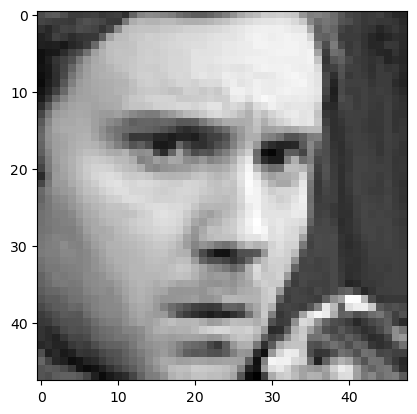

In [29]:
plt.imshow(pixels, cmap="gray")
plt.show()

### Converting whoel dataset to image array

In [30]:
images = []
labels = []

for index, row in df.iterrows():
    pixel_values = np.array(row["pixels"].split(), dtype="float32")
    pixel_values = pixel_values.reshape(48, 48, 1)

    images.append(pixel_values)
    labels.append(row["emotion"])

In [31]:
images = np.array(images)
labels = np.array(labels)

### Normalizing the Images

In [34]:
images = images / 255.0

### Checking Final Shape

In [35]:
print(images.shape)
print(labels.shape)

(35887, 48, 48, 1)
(35887,)


## Create Train, Val, Test Split using `Usage` column
* Do everything we have done bofore for train, val, and test sets
* For doing that we need to func 

In [37]:
df["Usage"].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [38]:
train_data = df[df["Usage"] == "Training"]
val_data = df[df["Usage"] == "PublicTest"]
test_data = df[df["Usage"] == "PrivateTest"]

### Convert Each Split into Image & Labels

In [39]:
def process_data(df):
    images = []
    labels = []

    for _, row in df.iterrows():
        pixels = np.array(row["pixels"].split(), dtype="float32")
        pixels = pixels.reshape(48, 48, 1)

        images.append(pixels)
        labels.append(row["emotion"])

    images = np.array(images) / 255.0
    labels = np.array(labels)

    return images, labels

In [40]:
X_train, y_train = process_data(train_data)
X_val, y_val = process_data(val_data)
X_test, y_test = process_data(test_data)

In [41]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(28709, 48, 48, 1) (28709,)
(3589, 48, 48, 1) (3589,)
(3589, 48, 48, 1) (3589,)


### Converting Labels to Categorical

In [43]:
from tensorflow.keras.utils import to_categorical

In [50]:
max(y_train)

np.int64(6)

In [51]:
min(y_train)

np.int64(0)

In [52]:
y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

## Now build the model
* Build CNN model using FER2013 dataset

In [57]:
from tensorflow.keras import layers, models
import keras

In [58]:
model = models.Sequential()

# input shape
model.add(keras.Input(shape=(48, 48, 1)))
# first layer / input layer
model.add(layers.Conv2D(32, # filter
                        (3, 3), # Kernel size
                        activation="relu", # activation function
                       ))
model.add(layers.MaxPooling2D(2, 2))

# hidden layer 1
model.add(layers.Conv2D(64, 
                        (3, 3),
                        activation="relu"
                       ))
model.add(layers.MaxPooling2D(2,2))

# hidden layer 2
model.add(layers.Conv2D(128,
                        (3,3),
                        activation="relu"
                       ))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(7, activation="softmax"))

### Compile the model

In [60]:
model.compile(
    optimizer="adam",
    loss = "categorical_crossentropy",
    metrics=['accuracy']
)

### Train the model

In [61]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data= (X_val, y_val)
)

Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.2968 - loss: 1.7344 - val_accuracy: 0.4113 - val_loss: 1.5436
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4116 - loss: 1.5144 - val_accuracy: 0.4589 - val_loss: 1.3957
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4631 - loss: 1.4047 - val_accuracy: 0.4787 - val_loss: 1.3444
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4989 - loss: 1.3273 - val_accuracy: 0.5102 - val_loss: 1.2774
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5175 - loss: 1.2776 - val_accuracy: 0.5283 - val_loss: 1.2449
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5315 - loss: 1.2399 - val_accuracy: 0.5419 - val_loss: 1.2171
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5508 - loss: 1.1924 - val_accuracy: 0.5439 - val_loss: 1.2088
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5617 - loss: 1.1583 - val_accu

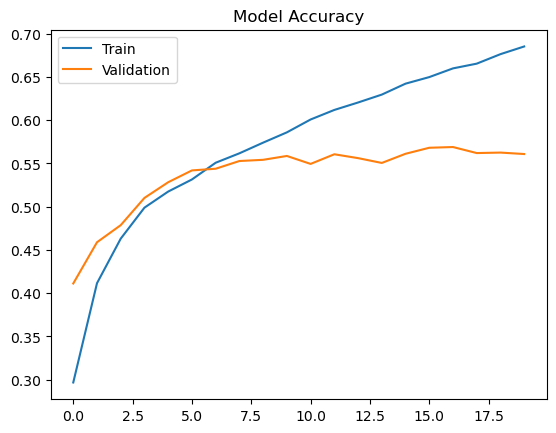

In [62]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(["Train", "Validation"])
plt.show()
